## Random Forest Model

Let's first start by loading the libraries we will be using.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import copy
import time
import random
import pyspark
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from pyspark.sql.functions import col, substring

# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We initialize our spark session.

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()

Let's then load the preprocessed data after feature engineering and labelling.

In [3]:
feat_data = spark.read.parquet('drive/My Drive/Soen471/data/labeled_features3.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))
feat_data = feat_data.withColumnRenamed("label_e", "label")
feat_data = feat_data.withColumn("model", substring("model", 6,1).cast(IntegerType()))

print(feat_data.count())

# highly imbalanced data
label_count_pd = feat_data.groupby('label').count().toPandas()
feat_data.limit(10).toPandas().head(10)

292142


,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,vibration_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,volt_rollingstd_3,rotate_rollingstd_3,pressure_rollingstd_3,vibration_rollingstd_3,volt_rollingstd_12,rotate_rollingstd_12,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,machineID,error1sum_rollingmean_12,error2sum_rollingmean_12,error3sum_rollingmean_12,error4sum_rollingmean_12,error5sum_rollingmean_12,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 06:00:00,155.926136,508.873216,103.217517,44.404096,168.808851,459.669547,103.067957,41.409164,169.366028,40.959647,456.401347,100.910854,7.114671,11.243900,3.651186,2.553561,0.151602,2.056678,0.108284,0.091922,0.000394,0.670628,0.013556,0.129090,60,0.0,0.0,0.0,0.0,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
1,2016-01-01 03:00:00,177.241489,443.717507,103.011478,37.057737,174.314186,450.696569,100.441772,40.051142,169.556059,40.749908,448.792799,100.251277,5.164997,26.434283,4.392684,2.929363,0.781903,4.248563,0.511725,0.168612,0.507840,4.670183,0.298848,0.072926,60,0.0,0.0,0.0,0.0,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
2,2016-01-01 00:00:00,170.262559,444.910532,107.530806,40.707467,170.484633,457.562043,100.751848,41.019130,166.773586,41.320703,450.162801,100.098801,10.525109,8.321757,6.273491,1.704244,0.332061,1.331433,0.767676,0.146732,0.633578,1.405945,0.360549,0.060784,60,0.0,0.0,0.0,0.0,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-31 21:00:00,168.169328,453.981021,98.461255,43.418780,169.776971,456.909157,98.917461,40.899594,166.512359,41.642311,451.107050,100.004211,13.073391,6.626638,2.534317,2.727416,2.789753,0.764817,0.346953,0.027524,1.101228,0.376190,0.066212,0.045780,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-31 18:00:00,181.583369,460.177215,92.763549,39.020584,170.272706,453.480797,98.386310,40.507900,167.148002,41.580618,450.474985,100.213763,0.529714,11.744239,0.998924,1.690766,0.196045,1.003252,0.768612,0.436406,0.167026,1.509488,0.193150,0.131995,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-31 15:00:00,161.923275,471.179402,104.251783,40.929688,164.797932,446.889030,100.060783,41.448674,164.108382,42.122185,447.659853,101.450707,4.124094,11.663660,4.626597,1.495421,1.491606,5.628500,0.077016,0.136219,0.204888,3.269642,0.217484,0.065363,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-31 12:00:00,167.431912,442.298992,100.193256,40.229322,163.062540,442.763560,99.445755,41.622275,163.607945,42.265109,445.499398,101.575411,2.949253,8.432152,4.731255,0.262570,1.404478,3.585269,1.302726,0.126604,0.605193,1.401294,0.515763,0.350314,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-31 09:00:00,170.152267,440.267578,96.336650,41.852004,163.247748,445.304944,101.090962,42.385029,163.894898,42.064928,445.573181,101.029689,2.902387,12.623303,5.891664,0.153193,0.581314,1.858875,0.495848,0.067000,0.100407,0.305849,0.145826,0.175761,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-31 06:00:00,159.684275,433.810148,99.461441,42.783680,164.023299,447.469174,102.041216,42.653336,165.401512,41.691746,442.872655,101.230104,7.314862,7.165871,3.437974,1.661660,0.024323,2.320095,0.387279,0.240286,0.116355,1.505692,0.194024,0.057104,60,0.0,0.0,0.0,0.0,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-31 03:00:00,154.981705,454.677523,101.791672,41.624095,163.418831,448.430676,102.840632,42.795697,166.756664,41.178150,446.168794,100.886666,1.826989,6.051152,0.121616,1.744729,0.958883,0.981814,0.53

However, the data is very imbalanced. Most of the time there are no failures at all. We will tackle this by undersampling.

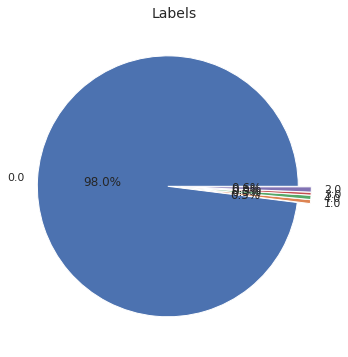

In [4]:
sns.set_theme(style="whitegrid")
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=label_count_pd['count'].tolist(), autopct="%.1f%%", explode=[0.05]*5, labels=label_count_pd['label'].tolist(), pctdistance=0.5)
plt.title("Labels", fontsize=14)
plt.show()

We remove some columns as input features.

In [5]:
label_var = ['label']
key_cols =['machineID','dt_truncated']
input_features = feat_data.columns
remove_cols = label_var + key_cols + ['failure','model_encoded']

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_cols)]
# Use cols
input_features

['volt_rollingmean_3',
 'rotate_rollingmean_3',
 'pressure_rollingmean_3',
 'vibration_rollingmean_3',
 'volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'vibration_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'volt_rollingstd_3',
 'rotate_rollingstd_3',
 'pressure_rollingstd_3',
 'vibration_rollingstd_3',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'error1sum_rollingmean_12',
 'error2sum_rollingmean_12',
 'error3sum_rollingmean_12',
 'error4sum_rollingmean_12',
 'error5sum_rollingmean_12',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'model',
 'age']

### Train/ Test split

Here, we assemble the features to be used as input features and split the data into training and testing. The split will be 10 months for training and 2 months for testing.

We then undersample the labels as 0 so the model is less biased.

In [6]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label','features')

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

# Undersampling
training = training.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0)

print(training.count())
print(testing.count())

52082
50708


As we can see below, it is less imbalanced than before.

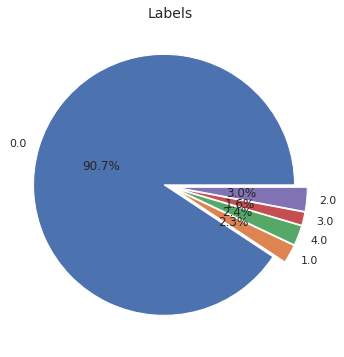

In [7]:
label_count_pd = training.groupby('label').count().toPandas()
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=label_count_pd['count'].tolist(), autopct="%.1f%%", explode=[0.05]*5, labels=label_count_pd['label'].tolist(), pctdistance=0.5)
plt.title("Labels", fontsize=14)
plt.show()

### Training

Here, we will then train the model from the pipeline and make predictions.

In [8]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])

# Train model.  This also runs the indexers.
model_rf = pipeline_rf.fit(training)

# Save model
datestamp = str(datetime.datetime.now());
rf_fileName = "RandomForest_" + datestamp;
rfDirfilename = '../models/' + rf_fileName;
model_rf.save(rfDirfilename)

# Make predictions.
predictions_rf = model_rf.transform(testing)
predictions_rf.groupby('indexedLabel', 'prediction').count().show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         2.0|       0.0|   13|
|         1.0|       1.0|  331|
|         3.0|       2.0|    2|
|         0.0|       1.0|   43|
|         0.0|       4.0|   12|
|         2.0|       2.0|  204|
|         3.0|       1.0|    2|
|         2.0|       3.0|    6|
|         4.0|       4.0|  130|
|         2.0|       4.0|    1|
|         2.0|       1.0|    2|
|         1.0|       2.0|    2|
|         0.0|       0.0|49651|
|         0.0|       2.0|   29|
|         4.0|       0.0|   31|
|         3.0|       3.0|  134|
|         0.0|       3.0|   26|
|         3.0|       0.0|   75|
|         4.0|       1.0|   14|
+------------+----------+-----+



In [9]:
predictions_rf.dtypes

[('machineID', 'string'),
 ('dt_truncated', 'timestamp'),
 ('label', 'double'),
 ('features', 'vector'),
 ('indexedLabel', 'double'),
 ('indexedFeatures', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

The prediction is obtained, the true label is the indexedLabel column and the prediction is prediction column. The probability is also obtained.

In [10]:
predictions_rf.show()

+---------+-------------------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|machineID|       dt_truncated|label|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+---------+-------------------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|       60|2016-01-01 06:00:00|  0.0|[155.926135776438...|         0.0|[155.926135776438...|[98.4152775930517...|[0.98415277593051...|       0.0|
|       60|2016-01-01 03:00:00|  0.0|[177.241488520938...|         0.0|[177.241488520938...|[98.4152775930517...|[0.98415277593051...|       0.0|
|       60|2016-01-01 00:00:00|  0.0|[170.262559141675...|         0.0|[170.262559141675...|[98.4152775930517...|[0.98415277593051...|       0.0|
|       60|2015-12-31 21:00:00|  0.0|[168.169327803014...|         0.0|[168.169327803014...|[98.4152775930517...|[0.98415277

### Evaluation

We then evaluate the model with the following metrics.

Area under ROC = 0.939612
Area under PR = 0.765028

Accuracy = 0.994912
Weighted Precision = 0.994888
Weighted Recall = 0.994912
F1 = 0.994782


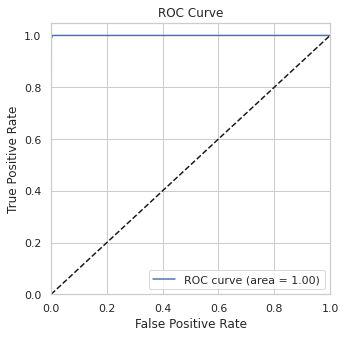

In [11]:
predictionAndLabels = predictions_rf.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('indexedLabel','probability').toPandas()
labels = predictions_rf_pddf["indexedLabel"]
prob = []
for dv in predictions_rf_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Having a more detailed look at the classes.

In [12]:
# Use sklearn
rf_result = predictions_rf.select('indexedLabel', 'prediction').toPandas()

rf_label = rf_result['indexedLabel'].tolist()
rf_prediction = rf_result['prediction'].tolist()

precision, recall, fscore, support = score(rf_label, rf_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.997609   0.84438776 0.86075949 0.80722892 0.90909091]
recall: [0.99778943 0.99399399 0.90265487 0.62910798 0.74285714]
fscore: [0.99769921 0.91310345 0.8812095  0.70712401 0.81761006]
support: [49761   333   226   213   175]


### Hyperparameter  Tuning

The model is already performing really well, using cross validation with grid search, we find the best set of parameters.

In [13]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                            featureSubsetStrategy="auto", impurity="gini", seed=123)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])


## Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxBins, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 7]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

## Define cross-validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="weightedPrecision"),
                          numFolds=3)

## Train model using CV
cvModel = crossval.fit(training)

In [15]:
datestamp = str(datetime.datetime.now());
rf_fileName = "CV_RandomForestClassificationModel";
rfDirfilename = '../models/' + rf_fileName;
cvModel.bestModel.save(rfDirfilename)

In [16]:
## Predict and evaluate
predictions = cvModel.transform(testing)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
r2 = evaluator.evaluate(predictions)
print("weightedPrecision on test data = %g" % r2)

weightedPrecision on test data = 0.99681


In [17]:
# Make predictions.
predictions_rf = cvModel.bestModel.transform(testing)
predictions_rf.groupby('indexedLabel', 'prediction').count().show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         1.0|       1.0|  330|
|         3.0|       2.0|    2|
|         0.0|       1.0|   44|
|         0.0|       4.0|   19|
|         2.0|       2.0|  219|
|         3.0|       1.0|    2|
|         2.0|       3.0|    7|
|         4.0|       4.0|  158|
|         1.0|       2.0|    3|
|         0.0|       0.0|49621|
|         4.0|       3.0|    1|
|         0.0|       2.0|   31|
|         4.0|       0.0|    2|
|         3.0|       3.0|  197|
|         0.0|       3.0|   46|
|         3.0|       0.0|   12|
|         4.0|       1.0|   14|
+------------+----------+-----+



The best parameters are found to be the following:

In [ ]:
print("Best MaxDepth: ",cvModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print("Best MaxBins: ",cvModel.bestModel.stages[-1]._java_obj.getMaxBins())
print("Best NumTrees: ",cvModel.bestModel.stages[-1]._java_obj.getNumTrees())
print("Best MinInstancesPerNode: ",cvModel.bestModel.stages[-1]._java_obj.getMinInstancesPerNode())


Best MaxDepth:  7
Best MaxBins:  20
Best NumTrees:  100
Best MinInstancesPerNode:  1


Area under ROC = 0.934564
Area under PR = 0.916852

Accuracy = 0.996391
Weighted Precision = 0.99681
Weighted Recall = 0.996391
F1 = 0.996522


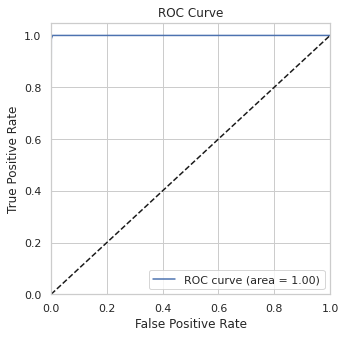

In [18]:
predictionAndLabels = predictions_rf.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('indexedLabel','probability').toPandas()
labels = predictions_rf_pddf["indexedLabel"]
prob = []
for dv in predictions_rf_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The main improvement after tuning is the area under PR, which went from 0.76 to 0.91. Let's take a look at the confusion matrix.

In [19]:
cm = confusion_matrix(predictions_rf.select('indexedLabel').collect(), predictions_rf.select('prediction').collect())

In [21]:
cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]

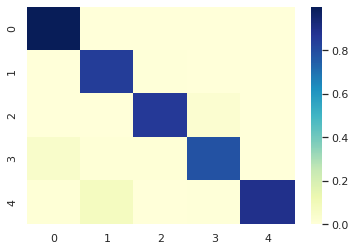

In [23]:
f = sns.heatmap(cm, cmap="YlGnBu")

Unexpectedly, we get really good results.

Let's have a look at the most important discriminating features to the Random Forest.

In [24]:
def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

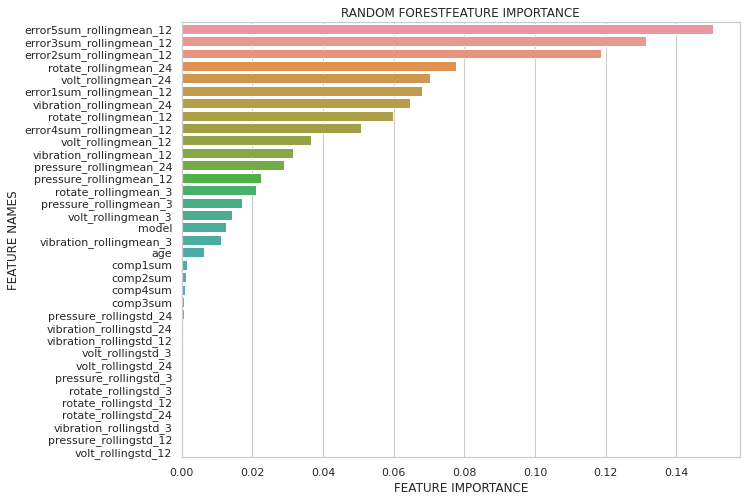

In [25]:
plot_feature_importance(model_rf.stages[-1].featureImportances, input_features,'RANDOM FOREST')

Surprisingly, the age is less important that we thought. Top 3 features were: 

- error5sum_rollingmean_12
- error3sum_rollingmean_12
- error2sum_rollingmean_12

In [43]:
# loaded_model = PipelineModel.load("drive/My Drive/Soen471/models/CV_RandomForestClassificationModel/")

In [42]:
# ## Predict and evaluate
# predictions = loaded_model.transform(testing)
# evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
# r2 = evaluator.evaluate(predictions)
# print("weightedPrecision on test data = %g" % r2)